# Data Modeling

In this notebook, I will model the credit risk dataset using three models:

    1. Logistic Regression
    2. K-Nearest Neighbor Model
    3. Decision Tree Classifier
    
The reason for using these models is because the main dependent variable, default, is binary. For each model I will perform a train-test split of 80%-20% and evaluate the accuracy of the model using accuracy score, classification report, and confusion matrix, to find the most accurate model. Additionally I will fine tune the parameters of the model using RandomizedSearchCV. 
In addition to modeling the entire dataset, I will also model the data by removing borrowers who have defaulted before to see if this improves the accuracy of any of the three models.


# The Data & Cleanup

To start off it is important to important to upload the dataset, clean it, and see the data type of the columns in the dataset. Furthermore it is important to see if any columns have any null values, and ways in which we can fill those null values to make our model give the proper and most accurate results. 

In [79]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import model_selection,linear_model, metrics, neighbors, tree
import pydotplus



In [83]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, accuracy_score, confusion_matrix, roc_auc_score, classification_report, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


In [86]:
df = pd.read_csv('credit risk.csv')

In [87]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [88]:
# Renaming Columns
df = df.rename(index=str, columns={"person_age":"Age", "person_income":"Income", "person_home_ownership":"home ownership", "person_emp_length":"Years_Employed","loan_intent":"intent","loan_amnt":"Amount","loan_int_rate":"Rate","loan_status":"Default","loan_percent_income":"Loan_Percent_Income","cb_person_default_on_file":"default on file","cb_person_cred_hist_length":"Credit_History","loan_grade":"grade"})

In [89]:
df.head()

,Age,Income,home ownership,Years_Employed,intent,grade,Amount,Rate,Default,Loan_Percent_Income,default on file,Credit_History
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [90]:
print(df)

       Age  Income home ownership  Years_Employed           intent grade  \
0       22   59000           RENT           123.0         PERSONAL     D   
1       21    9600            OWN             5.0        EDUCATION     B   
2       25    9600       MORTGAGE             1.0          MEDICAL     C   
3       23   65500           RENT             4.0          MEDICAL     C   
4       24   54400           RENT             8.0          MEDICAL     C   
...    ...     ...            ...             ...              ...   ...   
32576   57   53000       MORTGAGE             1.0         PERSONAL     C   
32577   54  120000       MORTGAGE             4.0         PERSONAL     A   
32578   65   76000           RENT             3.0  HOMEIMPROVEMENT     B   
32579   56  150000       MORTGAGE             5.0         PERSONAL     B   
32580   66   42000           RENT             2.0          MEDICAL     B   

       Amount   Rate  Default  Loan_Percent_Income default on file  \
0       35000  16

In [91]:
df.dtypes

Age                      int64
Income                   int64
home ownership          object
Years_Employed         float64
intent                  object
grade                   object
Amount                   int64
Rate                   float64
Default                  int64
Loan_Percent_Income    float64
default on file         object
Credit_History           int64
dtype: object

In [92]:
df.isnull().values.any()

True

In [93]:
na_df=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount
0,Rate,3116
1,Years_Employed,895


From the results above it can be seen that Rate and Years Employed are the only two columns with null values in this data set.

# Handling Missing Values

Before proceeding with modeling the data it is important, to fill in the null values in the interest rate (Rate) and years employed column so that model can be accurate. Even before that it important to see what rows in the set have null values. 

In [94]:
df[df['Rate'].isna()]

,Age,Income,home ownership,Years_Employed,intent,grade,Amount,Rate,Default,Loan_Percent_Income,default on file,Credit_History
39,23,71500,RENT,3.0,DEBTCONSOLIDATION,D,30000,NaN,1,0.42,N,4
50,24,78000,RENT,4.0,DEBTCONSOLIDATION,D,30000,NaN,1,0.38,Y,4
57,23,277000,OWN,3.0,PERSONAL,A,35000,NaN,0,0.13,N,4
59,24,12000,OWN,2.0,VENTURE,E,1750,NaN,0,0.15,Y,3
62,26,263000,MORTGAGE,0.0,EDUCATION,B,10000,NaN,1,0.04,N,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32547,53,4888,OWN,0.0,VENTURE,C,1400,NaN,1,0.29,Y,28
32552,65,45900,RENT,2.0,EDUCATION,C,10000,NaN,0,0.22,Y,19
32553,54,20000,RENT,2.0,MEDICAL,C,5000,NaN,0,0.25,N,28
32569,51,60000,MORTGAGE,1.0,PERSONAL,A,7500,NaN,0,0.13,N,23


In [95]:
df[df['Years_Employed'].isna()]

,Age,Income,home ownership,Years_Employed,intent,grade,Amount,Rate,Default,Loan_Percent_Income,default on file,Credit_History
105,22,12600,MORTGAGE,NaN,PERSONAL,A,2000,5.42,1,0.16,N,4
222,24,185000,MORTGAGE,NaN,EDUCATION,B,35000,12.42,0,0.19,N,2
379,24,16800,MORTGAGE,NaN,DEBTCONSOLIDATION,A,3900,NaN,1,0.23,N,3
407,25,52000,RENT,NaN,PERSONAL,B,24000,10.74,1,0.46,N,2
408,22,17352,MORTGAGE,NaN,EDUCATION,C,2250,15.27,0,0.13,Y,3
...,...,...,...,...,...,...,...,...,...,...,...,...
32285,38,12000,OWN,NaN,EDUCATION,A,4800,7.29,1,0.40,N,12
32328,51,18408,RENT,NaN,PERSONAL,C,1000,14.65,1,0.05,Y,20
32360,70,39996,RENT,NaN,MEDICAL,C,3600,15.23,0,0.09,Y,19
32453,56,32400,RENT,NaN,MEDICAL,A,8575,7.51,0,0.26,N,18


To fill in the null values, it is important to see the distribution for Years_Employed and rate to see if they are normally distributed. This way I can decide if I want to use the mean for the null value. Fortunately, I already have these results from another notebook, in which it was shown that these two columns aren't normally distributed. 

array([[<AxesSubplot:title={'center':'Rate'}>]], dtype=object)

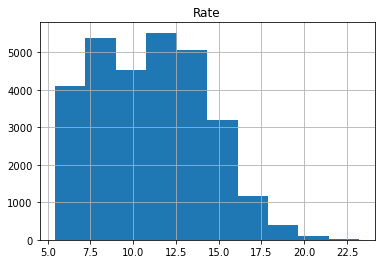

In [96]:
df.hist(column = 'Rate')

array([[<AxesSubplot:title={'center':'Years_Employed'}>]], dtype=object)

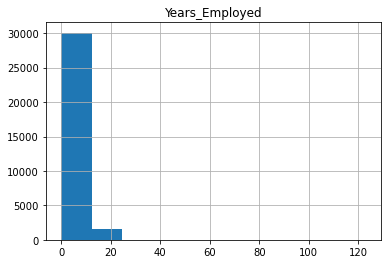

In [97]:
df.hist(column = 'Years_Employed')

array([[<AxesSubplot:title={'center':'Age'}>]], dtype=object)

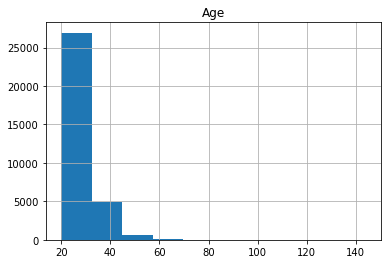

In [98]:
df.hist(column = 'Age')

Since neither of these columns are normally distributed, I can't use the mean to fill in the null values, and will instead use the median.

In [99]:
df['Rate'].fillna((df['Rate'].median()), inplace=True)
df['Years_Employed'].fillna((df['Years_Employed'].mean()), inplace=True)

In [100]:
na_df=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount


In [101]:
print(df['Age'].value_counts())

23     3889
22     3633
24     3549
25     3037
26     2477
27     2138
28     1854
29     1687
30     1316
21     1229
31     1142
32      964
33      856
34      709
35      620
36      548
37      478
38      373
39      302
40      271
41      241
42      188
43      164
44      141
45      108
47       94
46       94
48       75
50       52
49       49
51       39
52       36
53       30
54       24
55       20
58       19
56       15
20       15
57       15
60       15
66        9
65        9
61        9
62        7
64        7
70        7
59        5
69        5
73        3
144       3
63        3
123       2
80        1
76        1
78        1
94        1
67        1
84        1
Name: Age, dtype: int64


By looking at the value count of age, it seems that while most borrowers are in their 20s, there are some odd borrowers who are more than 100 years old. This is clearly a mistake and needs to corrected before inputing the dataset in the model.

In [102]:
df = df[df['Age']<100]

In [103]:
print(df['Age'].value_counts())

23    3889
22    3633
24    3549
25    3037
26    2477
27    2138
28    1854
29    1687
30    1316
21    1229
31    1142
32     964
33     856
34     709
35     620
36     548
37     478
38     373
39     302
40     271
41     241
42     188
43     164
44     141
45     108
46      94
47      94
48      75
50      52
49      49
51      39
52      36
53      30
54      24
55      20
58      19
56      15
20      15
57      15
60      15
65       9
66       9
61       9
64       7
62       7
70       7
59       5
69       5
73       3
63       3
80       1
78       1
94       1
76       1
84       1
67       1
Name: Age, dtype: int64


In [104]:
print(df['Years_Employed'].value_counts())

0.000000      4105
2.000000      3848
3.000000      3456
5.000000      2946
1.000000      2915
4.000000      2872
6.000000      2666
7.000000      2195
8.000000      1687
9.000000      1367
4.789686       895
11.000000      740
10.000000      696
12.000000      574
13.000000      426
14.000000      335
15.000000      238
16.000000      165
17.000000      129
18.000000      104
19.000000       64
20.000000       42
21.000000       38
22.000000       19
24.000000       10
23.000000       10
25.000000        8
26.000000        6
27.000000        5
31.000000        4
28.000000        3
123.000000       2
30.000000        2
34.000000        1
29.000000        1
41.000000        1
38.000000        1
Name: Years_Employed, dtype: int64


Looking at Years employed numbers it seems that there borrowers who have more than 40 Years of employment. we need to also get rid of those borrowers from the dataset.

In [105]:
df = df[df['Years_Employed']<=40]

In [106]:
print(df)

       Age  Income home ownership  Years_Employed           intent grade  \
1       21    9600            OWN             5.0        EDUCATION     B   
2       25    9600       MORTGAGE             1.0          MEDICAL     C   
3       23   65500           RENT             4.0          MEDICAL     C   
4       24   54400           RENT             8.0          MEDICAL     C   
5       21    9900            OWN             2.0          VENTURE     A   
...    ...     ...            ...             ...              ...   ...   
32576   57   53000       MORTGAGE             1.0         PERSONAL     C   
32577   54  120000       MORTGAGE             4.0         PERSONAL     A   
32578   65   76000           RENT             3.0  HOMEIMPROVEMENT     B   
32579   56  150000       MORTGAGE             5.0         PERSONAL     B   
32580   66   42000           RENT             2.0          MEDICAL     B   

       Amount   Rate  Default  Loan_Percent_Income default on file  \
1        1000  11

# General Trends

Common trends of the dataset as it relates to age, years employed, credit history, default, and rate.

<AxesSubplot:xlabel='Age', ylabel='Rate'>

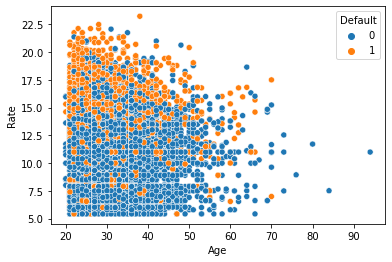

In [107]:
sns.scatterplot(data=df, x="Age", y="Rate", hue="Default")

<AxesSubplot:xlabel='Years_Employed', ylabel='Rate'>

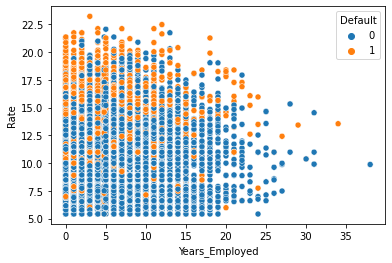

In [108]:
sns.scatterplot(data=df, x="Years_Employed", y="Rate", hue="Default")

<AxesSubplot:xlabel='Credit_History', ylabel='Rate'>

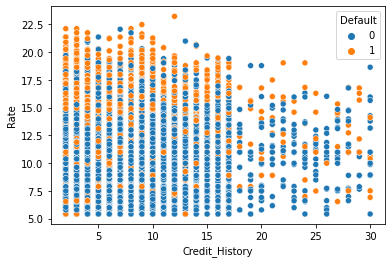

In [109]:
sns.scatterplot(data=df, x="Credit_History", y="Rate", hue="Default")

<AxesSubplot:xlabel='Amount', ylabel='Rate'>

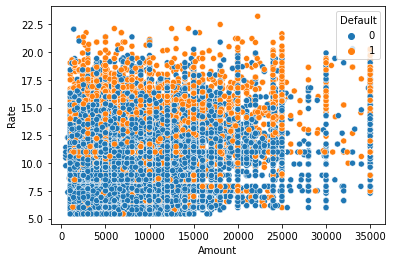

In [110]:
sns.scatterplot(data=df, x="Amount", y="Rate", hue="Default")

From the trends above it can be seen that those that had more credit history, were older, and had more years of employment generally tended to get loans with lower interest rates. Also loans with higher amounts had lower rates

<AxesSubplot:>

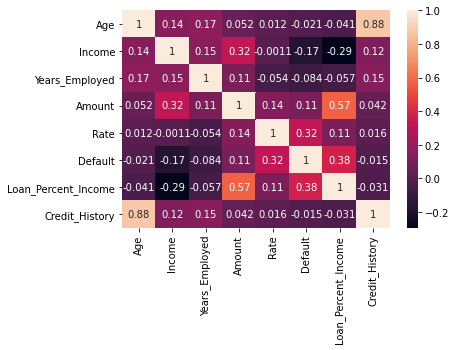

In [111]:
sns.heatmap(df.corr(), annot = True)

From the Correlation map above the following obervations can be made:

1. Income, Credit History, Years Employed, and Age have a negative correlation with default which means that the higher these are the less likely a person is going to default

2. Loan(% Income), Rate, and amount of loan have a positive correlation with default which means that the higher these are the more likely a person is going to default

# Creating Dummy Variables

By Looking at the data types of the columns in this dataset there are four columns that aren't numerical. They are intent, home ownership, grade, and default of file. These are the columns for which dummy variables will need to be created. Before doing that it important to see the value counts for these columns.

In [112]:
print(df['grade'].value_counts())

A    10775
B    10448
C     6456
D     3625
E      964
F      241
G       64
Name: grade, dtype: int64


In [113]:
print(df['intent'].value_counts())

EDUCATION            6451
MEDICAL              6070
VENTURE              5716
PERSONAL             5519
DEBTCONSOLIDATION    5212
HOMEIMPROVEMENT      3605
Name: intent, dtype: int64


In [114]:
print(df['home ownership'].value_counts())

RENT        16441
MORTGAGE    13441
OWN          2584
OTHER         107
Name: home ownership, dtype: int64


In [115]:
print(df['default on file'].value_counts())

N    26829
Y     5744
Name: default on file, dtype: int64


In [116]:
Features = ['grade', 'intent', 'home ownership', 'default on file']
df_features = df[Features]

In [117]:
dummy = pd.get_dummies(df_features, drop_first=True)

In [118]:
dummy.head()

,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,intent_EDUCATION,intent_HOMEIMPROVEMENT,intent_MEDICAL,intent_PERSONAL,intent_VENTURE,home ownership_OTHER,home ownership_OWN,home ownership_RENT,default on file_Y
1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0
2,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
4,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1
5,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0


In [119]:
df = pd.concat([df, dummy], axis=1)

In [120]:
print(df)

       Age  Income home ownership  Years_Employed           intent grade  \
1       21    9600            OWN             5.0        EDUCATION     B   
2       25    9600       MORTGAGE             1.0          MEDICAL     C   
3       23   65500           RENT             4.0          MEDICAL     C   
4       24   54400           RENT             8.0          MEDICAL     C   
5       21    9900            OWN             2.0          VENTURE     A   
...    ...     ...            ...             ...              ...   ...   
32576   57   53000       MORTGAGE             1.0         PERSONAL     C   
32577   54  120000       MORTGAGE             4.0         PERSONAL     A   
32578   65   76000           RENT             3.0  HOMEIMPROVEMENT     B   
32579   56  150000       MORTGAGE             5.0         PERSONAL     B   
32580   66   42000           RENT             2.0          MEDICAL     B   

       Amount   Rate  Default  Loan_Percent_Income  ... grade_G  \
1        1000  11.14

In [121]:
cor = df.corr(method = 'spearman')['Default'].sort_values(ascending =False)
print(cor)

Default                   1.000000
grade_D                   0.318865
Loan_Percent_Income       0.316034
Rate                      0.297993
home ownership_RENT       0.238437
grade_E                   0.180128
default on file_Y         0.178995
grade_F                   0.101845
Amount                    0.083970
grade_G                   0.082311
intent_MEDICAL            0.056620
intent_HOMEIMPROVEMENT    0.036591
home ownership_OTHER      0.012541
grade_C                  -0.012980
intent_PERSONAL          -0.021236
Credit_History           -0.023736
Age                      -0.033144
intent_EDUCATION         -0.055307
intent_VENTURE           -0.078197
grade_B                  -0.092144
Years_Employed           -0.094748
home ownership_OWN       -0.101986
Income                   -0.272089
Name: Default, dtype: float64


# Data Distribution

The next step is to see how the nuemrical data is distributed and see if what if any kind of scalling is necessary for pre-processing.

array([[<AxesSubplot:title={'center':'Age'}>]], dtype=object)

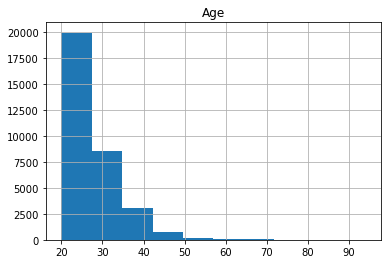

In [122]:
df.hist(column = 'Age')

array([[<AxesSubplot:title={'center':'Years_Employed'}>]], dtype=object)

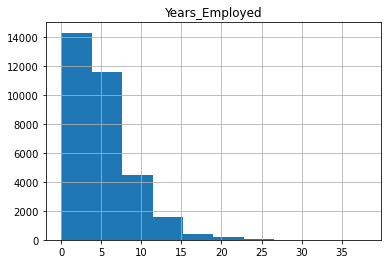

In [123]:
df.hist(column = 'Years_Employed')

array([[<AxesSubplot:title={'center':'Rate'}>]], dtype=object)

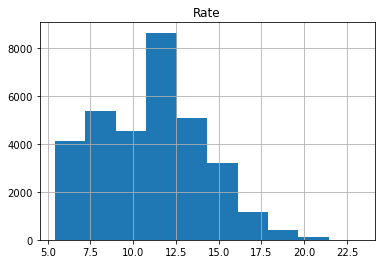

In [124]:
df.hist(column = 'Rate')

array([[<AxesSubplot:title={'center':'Credit_History'}>]], dtype=object)

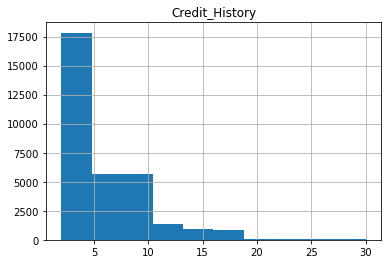

In [125]:
df.hist(column = 'Credit_History')

array([[<AxesSubplot:title={'center':'Amount'}>]], dtype=object)

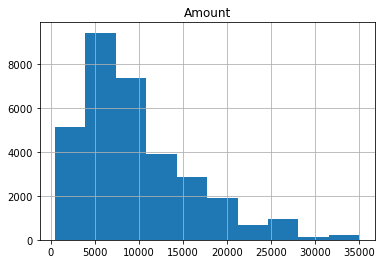

In [126]:
df.hist(column = 'Amount')

array([[<AxesSubplot:title={'center':'Loan_Percent_Income'}>]],
      dtype=object)

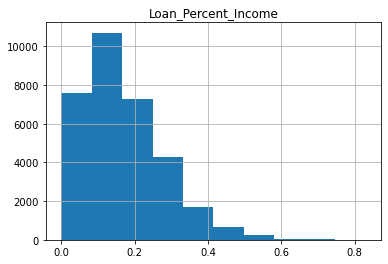

In [127]:
df.hist(column = 'Loan_Percent_Income')

array([[<AxesSubplot:title={'center':'Income'}>]], dtype=object)

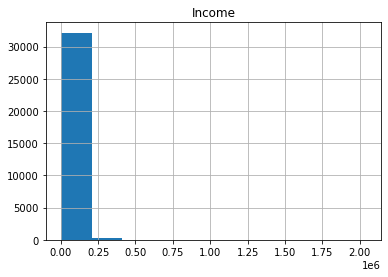

In [128]:
df.hist(column = 'Income')

A quick look at the numerical columns and it can be seen that they are skewed to the left. But since the main dependent variable, default, is binary we need to used a logistic regression. As a result of which scaling the data isn't necessary.

In [129]:
df.describe()

,Age,Income,Years_Employed,Amount,Rate,Default,Loan_Percent_Income,Credit_History,grade_B,grade_C,...,grade_G,intent_EDUCATION,intent_HOMEIMPROVEMENT,intent_MEDICAL,intent_PERSONAL,intent_VENTURE,home ownership_OTHER,home ownership_OWN,home ownership_RENT,default on file_Y
count,32573.000000,3.257300e+04,32573.000000,32573.000000,32573.000000,32573.000000,32573.000000,32573.000000,32573.000000,32573.000000,...,32573.000000,32573.000000,32573.000000,32573.000000,32573.000000,32573.000000,32573.000000,32573.000000,32573.000000,32573.000000
mean,27.716882,6.587903e+04,4.781161,9588.220305,11.009577,0.218187,0.170205,5.803518,0.320756,0.198201,...,0.001965,0.198047,0.110674,0.186351,0.169435,0.175483,0.003285,0.079330,0.504743,0.176342
std,6.198825,5.253265e+04,3.974126,6320.241199,3.081650,0.413021,0.106755,4.052540,0.466775,0.398650,...,0.044283,0.398534,0.313733,0.389395,0.375141,0.380385,0.057221,0.270257,0.499985,0.381117
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,8.490000,0.000000,0.090000,3.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.110000,0.000000,0.230000,8.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,94.000000,2.039784e+06,38.000000,35000.000000,23.220000,1.000000,0.830000,30.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Train/Split Data

Before we model out data it is import to split the data into train and test sets. I will use a 80-20 Train-test split.

In [130]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='Default'), 
                                                    df.Default, test_size=0.2, 
                                                    random_state=50)

In [131]:
X_train.dtypes


Age                         int64
Income                      int64
home ownership             object
Years_Employed            float64
intent                     object
grade                      object
Amount                      int64
Rate                      float64
Loan_Percent_Income       float64
default on file            object
Credit_History              int64
grade_B                     uint8
grade_C                     uint8
grade_D                     uint8
grade_E                     uint8
grade_F                     uint8
grade_G                     uint8
intent_EDUCATION            uint8
intent_HOMEIMPROVEMENT      uint8
intent_MEDICAL              uint8
intent_PERSONAL             uint8
intent_VENTURE              uint8
home ownership_OTHER        uint8
home ownership_OWN          uint8
home ownership_RENT         uint8
default on file_Y           uint8
dtype: object

In [132]:
X_test.dtypes

Age                         int64
Income                      int64
home ownership             object
Years_Employed            float64
intent                     object
grade                      object
Amount                      int64
Rate                      float64
Loan_Percent_Income       float64
default on file            object
Credit_History              int64
grade_B                     uint8
grade_C                     uint8
grade_D                     uint8
grade_E                     uint8
grade_F                     uint8
grade_G                     uint8
intent_EDUCATION            uint8
intent_HOMEIMPROVEMENT      uint8
intent_MEDICAL              uint8
intent_PERSONAL             uint8
intent_VENTURE              uint8
home ownership_OTHER        uint8
home ownership_OWN          uint8
home ownership_RENT         uint8
default on file_Y           uint8
dtype: object

In [133]:
# Dropping object columns
names_list = ['home ownership', 'intent', 'grade', 'default on file']
names_train = X_train[names_list]
names_test = X_test[names_list]
X_train.drop(columns=names_list, inplace=True)
X_test.drop(columns=names_list, inplace=True)


# Logistic Regression

In [134]:
LG = LogisticRegression()

LG.fit(X_train, y_train)



LogisticRegression()

In [135]:
# Intercept of Logistic Regression

LG.intercept_[0]

-2.148416749067799e-09

In [136]:
# Coefficients of Logistic Regression

LG.coef_[0]

array([-5.18931663e-08, -4.06783915e-05, -2.45179014e-08,  1.06479971e-04,
        8.48250139e-08,  2.62841269e-09, -7.56052227e-09, -5.55508467e-09,
       -1.22181467e-09,  1.08548397e-08,  3.38420324e-09,  9.89860446e-10,
        4.05365643e-10, -2.91035222e-09,  1.68541017e-09,  1.23392867e-09,
       -1.06083726e-09, -3.65533973e-09,  9.67316755e-11, -4.04728858e-09,
        8.18999973e-09,  7.02606159e-09])

In [137]:
LG.score(X_test, y_test)

0.8033768227168073

In [138]:
# Confusion Matrix For Logistic Regression
y_LG_Pred = LG.predict(X_test)
LG_CM = confusion_matrix(y_test, y_LG_Pred)
print(LG_CM)

[[5005   90]
 [1191  229]]


In [139]:
# Classfication Report for Logistic Regression

print(classification_report(y_test,y_LG_Pred))

              precision    recall  f1-score   support

           0       0.81      0.98      0.89      5095
           1       0.72      0.16      0.26      1420

    accuracy                           0.80      6515
   macro avg       0.76      0.57      0.57      6515
weighted avg       0.79      0.80      0.75      6515



In [140]:
# Training and Test Accuracy for Logistic regression

Training_accuracy = LG.score(X_train, y_train)
Testing_accuracy = LG.score(X_test, y_test)

print("Training accuracy of Logistic Regression model is:{:0.2f}".format(Training_accuracy))

print("Testing accuracy of Logistic Regression model is:{:0.2f}".format(Testing_accuracy))




Training accuracy of Logistic Regression model is:0.80
Testing accuracy of Logistic Regression model is:0.80


Based on the results of the accuracy score, it seems that our Logistic Regression model, give us 80% accuracy. While this is a relative high accuracy, it is also important to explore other models to see if they would have a higher accuracy.

# kNN Model

In [141]:
kNN = KNeighborsClassifier(n_neighbors=150)

kNN.fit(X_train, y_train)



KNeighborsClassifier(n_neighbors=150)

In [142]:
kNN.score(X_test, y_test)

0.8359171143514965

In [143]:
y_kNN_Pred = kNN.predict(X_test)
kNN_CM = confusion_matrix(y_test, y_kNN_Pred)
print(kNN_CM)

[[4901  194]
 [ 875  545]]


In [144]:
print(classification_report(y_test,y_kNN_Pred))

              precision    recall  f1-score   support

           0       0.85      0.96      0.90      5095
           1       0.74      0.38      0.50      1420

    accuracy                           0.84      6515
   macro avg       0.79      0.67      0.70      6515
weighted avg       0.82      0.84      0.82      6515



In [145]:
# Training and Test Accuracy for kNN

Training_accuracy_kNN = kNN.score(X_train, y_train)
Testing_accuracy_kNN = kNN.score(X_test, y_test)

print("Training accuracy of kNN model is:{:0.2f}".format(Training_accuracy_kNN))

print("Testing accuracy of kNN model is:{:0.2f}".format(Testing_accuracy_kNN))




Training accuracy of kNN model is:0.84
Testing accuracy of kNN model is:0.84


Based on the results of the accuracy score, it seems that the kNN model, give us 84% accuracy. While this is higher than the Logistic Regression Model, it is important to test out the Decision Tree Classifier model.

# Decision Tree Classifier

For the Decision Tree, two models will be used: Entrophy and Gini. 

In [146]:
# entrophy Decision Tree
DT_1 = DecisionTreeClassifier(criterion="entropy", random_state = 1234)

DT_1.fit(X_train, y_train)



DecisionTreeClassifier(criterion='entropy', random_state=1234)

In [147]:
DT_1.score(X_test, y_test)

0.8990023023791252

In [148]:
y_DT_1_Pred = DT_1.predict(X_test)
DT_1_CM = confusion_matrix(y_test, y_DT_1_Pred)
print(DT_1_CM)

[[4746  349]
 [ 309 1111]]


In [149]:
print(classification_report(y_test,y_DT_1_Pred))

              precision    recall  f1-score   support

           0       0.94      0.93      0.94      5095
           1       0.76      0.78      0.77      1420

    accuracy                           0.90      6515
   macro avg       0.85      0.86      0.85      6515
weighted avg       0.90      0.90      0.90      6515



In [150]:

Training_accuracy_DT_1 = DT_1.score(X_train, y_train)
Testing_accuracy_DT_1 = DT_1.score(X_test, y_test)

print("Training accuracy of Decision Tree with Entrophy model is:{:0.2f}".format(Training_accuracy_DT_1))

print("Testing accuracy of Decision Tree with Entrophy model is:{:0.2f}".format(Testing_accuracy_DT_1))




Training accuracy of Decision Tree with Entrophy model is:1.00
Testing accuracy of Decision Tree with Entrophy model is:0.90


Using the Decision Tree classifier with the entrophy method has an accuracy of 90%

In [151]:
#Gini Decision Tree

# entrophy Decision Tree
DT_2 = DecisionTreeClassifier(criterion="gini", random_state = 1234)

DT_2.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1234)

In [152]:
DT_2.score(X_test, y_test)

0.8867229470452801

In [153]:
y_DT_2_Pred = DT_2.predict(X_test)
DT_2_CM = confusion_matrix(y_test, y_DT_2_Pred)
print(DT_2_CM)

[[4691  404]
 [ 334 1086]]


In [154]:
print(classification_report(y_test,y_DT_2_Pred))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93      5095
           1       0.73      0.76      0.75      1420

    accuracy                           0.89      6515
   macro avg       0.83      0.84      0.84      6515
weighted avg       0.89      0.89      0.89      6515



In [155]:
Training_accuracy_DT_2 = DT_2.score(X_train, y_train)
Testing_accuracy_DT_2 = DT_2.score(X_test, y_test)

print("Training accuracy of Decision Tree with Gini model is:{:0.2f}".format(Training_accuracy_DT_2))

print("Testing accuracy of Decision Tree with Gini model is:{:0.2f}".format(Testing_accuracy_DT_2))

Training accuracy of Decision Tree with Gini model is:1.00
Testing accuracy of Decision Tree with Gini model is:0.89


It seems that the decision tree model, is the most accurate of the three.

# ROC-AUC Curves

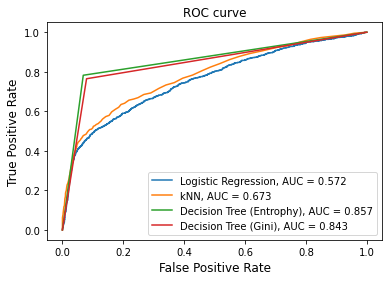

In [156]:
#ROC-AUC For all models

# Logistic Regression
Log_ROC = roc_auc_score(y_test, y_LG_Pred)
fpr, tpr, thresh = metrics.roc_curve(y_test, LG.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label=f'Logistic Regression, AUC = {str(round(Log_ROC,3))}')

#kNN
kNN_ROC = roc_auc_score(y_test, y_kNN_Pred)
fpr, tpr, thresh = metrics.roc_curve(y_test, kNN.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label=f'kNN, AUC = {str(round(kNN_ROC,3))}')

#Decision Tree with entrophy
DT_1_ROC = roc_auc_score(y_test, y_DT_1_Pred)
fpr, tpr, thresh = metrics.roc_curve(y_test, DT_1.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label=f'Decision Tree (Entrophy), AUC = {str(round(DT_1_ROC,3))}')

#Decision Tree with gini
DT_2_ROC = roc_auc_score(y_test, y_DT_2_Pred)
fpr, tpr, thresh = metrics.roc_curve(y_test, DT_2.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label=f'Decision Tree (Gini), AUC = {str(round(DT_2_ROC,3))}')


plt.ylabel("True Positive Rate", fontsize=12)
plt.xlabel("False Positive Rate", fontsize=12)
plt.title("ROC curve")
plt.legend()
plt.show()

Based on the ROC-AUC Curve shown is seems that the best model is Decision Tree using the Entrophy method.

# Hypertuning Parameters

In [157]:
#Logistic Regression
param_grid = {'penalty': ['l1','l2'], 'C': [0.001, 0.1, 1, 10, 100]}

LG_cv = RandomizedSearchCV(LG, param_grid, cv=5)

LG_cv.fit(X_train, y_train)

LG_cv.best_params_

LG_cv.best_score_

C:\Users\Abhijit Pawar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Abhijit Pawar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Abhijit Pawar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Abhijit Pawar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Abhijit Pawar\anaconda3\lib\

C:\Users\Abhijit Pawar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Abhijit Pawar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Abhijit Pawar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Abhijit Pawar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Abhijit Pawar\anaconda3\lib\

C:\Users\Abhijit Pawar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Abhijit Pawar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Abhijit Pawar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Abhijit Pawar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Abhijit Pawar\anaconda3\lib\

0.8039372332539954

In [166]:
#kNN
param_grid_knn = {'n_neighbors':np.arange(1,50)}
KNN = KNeighborsClassifier()
kNN_CV = RandomizedSearchCV(KNN, param_grid_knn, cv=5)
kNN_CV.fit(X_train, y_train)

print("Best Score:" + str(kNN_CV.best_score_))
print("Best Parameters: " + str(kNN_CV.best_params_))


Best Score:0.839435197666899
Best Parameters: {'n_neighbors': 32}


In [164]:
# Decision Tree

param_grid_DT = {'max_depth': [2, 3, 5, 10, 20],'min_samples_leaf': [5, 10, 20, 50, 100],'criterion': ["gini", "entropy"]}


DT = DecisionTreeClassifier()
DT_CV = RandomizedSearchCV(DT, param_grid_DT, cv=5)
DT_CV.fit(X_train, y_train)


print("Best Score:" + str(DT_CV.best_score_))
print("Best Parameters: " + str(DT_CV.best_params_))


Best Score:0.917415142388003
Best Parameters: {'min_samples_leaf': 50, 'max_depth': 20, 'criterion': 'entropy'}


Based on the Hyperparameter Tuning using Randomized Grid Search CV, the following conclusions can be drawn:

1. Even with hyperparameter tuning, the best accuracy that the Logistic Regression can have is 80%. Which means that the Logistic Regression used is the best one

2. For the Decision Tree classifier the best method to use is entropy with a max depth of 20

3. For kNN the best number of neighbors is 32

# Alternate Modeling Excluding Borrowers Who Defaulted Before

The previous models included all borrowers, even those that had defaulted before. Therefore it important to model borrowers that didn't default before only. It is important to this type of modeling as these are borrowers who either have little to no credit history or have haven't defaulted. This will give us true representation of what the risk is associated with loans given out to borrower, as we don't know for certain if that borrower will default or not.

In [168]:
df.head()

,Age,Income,home ownership,Years_Employed,intent,grade,Amount,Rate,Default,Loan_Percent_Income,...,grade_G,intent_EDUCATION,intent_HOMEIMPROVEMENT,intent_MEDICAL,intent_PERSONAL,intent_VENTURE,home ownership_OTHER,home ownership_OWN,home ownership_RENT,default on file_Y
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,...,0,1,0,0,0,0,0,1,0,0
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,...,0,0,0,1,0,0,0,0,0,0
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,...,0,0,0,1,0,0,0,0,1,0
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,...,0,0,0,1,0,0,0,0,1,1
5,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,...,0,0,0,0,0,1,0,1,0,0


In [172]:
df_ND = df[df['default on file_Y'] == 0]

In [173]:
print(df_ND)

       Age  Income home ownership  Years_Employed           intent grade  \
1       21    9600            OWN             5.0        EDUCATION     B   
2       25    9600       MORTGAGE             1.0          MEDICAL     C   
3       23   65500           RENT             4.0          MEDICAL     C   
5       21    9900            OWN             2.0          VENTURE     A   
6       26   77100           RENT             8.0        EDUCATION     B   
...    ...     ...            ...             ...              ...   ...   
32576   57   53000       MORTGAGE             1.0         PERSONAL     C   
32577   54  120000       MORTGAGE             4.0         PERSONAL     A   
32578   65   76000           RENT             3.0  HOMEIMPROVEMENT     B   
32579   56  150000       MORTGAGE             5.0         PERSONAL     B   
32580   66   42000           RENT             2.0          MEDICAL     B   

       Amount   Rate  Default  Loan_Percent_Income  ... grade_G  \
1        1000  11.14

In [177]:
X_ND_train, X_ND_test, y_ND_train, y_ND_test = train_test_split(df_ND.drop(columns='Default'), 
                                                    df_ND.Default, test_size=0.2, 
                                                    random_state=50)

In [178]:
names_list = ['home ownership', 'intent', 'grade', 'default on file']
names_train = X_ND_train[names_list]
names_test = X_ND_test[names_list]
X_ND_train.drop(columns=names_list, inplace=True)
X_ND_test.drop(columns=names_list, inplace=True)


In [179]:
# Logistic Regression

LG_ND = LogisticRegression()

LG_ND.fit(X_ND_train, y_ND_train)

LogisticRegression()

In [181]:
# Accuracy score for logistic Regression for non-default borrowers

LG_ND.score(X_ND_test, y_ND_test)

0.8524040253447633

In [183]:
# Confusion Matrix for Logistic Regression for non-default borrowers

y_LG_ND_Pred = LG_ND.predict(X_ND_test)
LG_ND_CM = confusion_matrix(y_ND_test, y_LG_ND_Pred)
print(LG_ND_CM)

[[4328   95]
 [ 697  246]]


In [185]:
# Classification Report for Logistic Regression for non-default borrowers
print(classification_report(y_ND_test,y_LG_ND_Pred))


              precision    recall  f1-score   support

           0       0.86      0.98      0.92      4423
           1       0.72      0.26      0.38       943

    accuracy                           0.85      5366
   macro avg       0.79      0.62      0.65      5366
weighted avg       0.84      0.85      0.82      5366



In [186]:
# fitting kNN TO Non-default borrowers
kNN.fit(X_ND_train, y_ND_train)

KNeighborsClassifier(n_neighbors=150)

In [187]:
# Accuracy score of kNN for non-default borrowers

kNN.score(X_ND_test, y_ND_test)

0.8715989563920984

In [188]:
# Confusion Matrix for kNN  for non-default borrowers

y_kNN_ND_Pred = kNN.predict(X_ND_test)
kNN_ND_CM = confusion_matrix(y_ND_test, y_kNN_ND_Pred)
print(kNN_ND_CM)

[[4269  154]
 [ 535  408]]


In [189]:
# Classification Report for kNN for non-default borrowers
print(classification_report(y_ND_test,y_kNN_ND_Pred))


              precision    recall  f1-score   support

           0       0.89      0.97      0.93      4423
           1       0.73      0.43      0.54       943

    accuracy                           0.87      5366
   macro avg       0.81      0.70      0.73      5366
weighted avg       0.86      0.87      0.86      5366



In [190]:
# fitting Decision Tree with entropy To Non-default borrowers
DT_1.fit(X_ND_train, y_ND_train)

DecisionTreeClassifier(criterion='entropy', random_state=1234)

In [192]:
# Accuracy score of Decision Tree with entropy for non-default borrowers

DT_1.score(X_ND_test, y_ND_test)

0.9030935519940365

In [194]:
# Confusion Matrix of Decision Tree with entropy for non-default borrowers

y_DT_1_ND_Pred = DT_1.predict(X_ND_test)
DT_1_ND_CM = confusion_matrix(y_ND_test, y_DT_1_ND_Pred)
print(DT_1_ND_CM)

[[4144  279]
 [ 241  702]]


In [195]:
# Classification Report of Decision Tree with entropy for non-default borrowers
print(classification_report(y_ND_test,y_DT_1_ND_Pred))


              precision    recall  f1-score   support

           0       0.95      0.94      0.94      4423
           1       0.72      0.74      0.73       943

    accuracy                           0.90      5366
   macro avg       0.83      0.84      0.84      5366
weighted avg       0.90      0.90      0.90      5366



In [196]:
# fitting Decision Tree with Gini To Non-default borrowers
DT_2.fit(X_ND_train, y_ND_train)

DecisionTreeClassifier(random_state=1234)

In [197]:
# Accuracy score of Decision Tree with Gini for non-default borrowers

DT_2.score(X_ND_test, y_ND_test)

0.8956392098397317

In [198]:
# Confusion Matrix of Decision Tree with Gini for non-default borrowers

y_DT_2_ND_Pred = DT_2.predict(X_ND_test)
DT_2_ND_CM = confusion_matrix(y_ND_test, y_DT_2_ND_Pred)
print(DT_2_ND_CM)

[[4094  329]
 [ 231  712]]


In [199]:
# Classification Report of Decision Tree with Gini for non-default borrowers
print(classification_report(y_ND_test,y_DT_2_ND_Pred))


              precision    recall  f1-score   support

           0       0.95      0.93      0.94      4423
           1       0.68      0.76      0.72       943

    accuracy                           0.90      5366
   macro avg       0.82      0.84      0.83      5366
weighted avg       0.90      0.90      0.90      5366



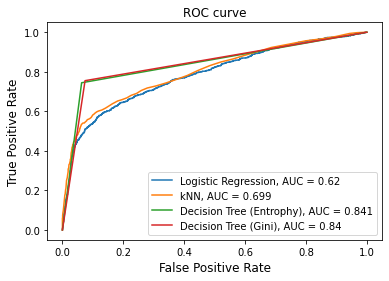

In [200]:
# ROC-AUC Curve for Non-Deafult borrowers

# Logistic Regression
Log_ND_ROC = roc_auc_score(y_ND_test, y_LG_ND_Pred)
fpr, tpr, thresh = metrics.roc_curve(y_ND_test, LG.predict_proba(X_ND_test)[:,1])
plt.plot(fpr, tpr, label=f'Logistic Regression, AUC = {str(round(Log_ND_ROC,3))}')

#kNN
kNN_ND_ROC = roc_auc_score(y_ND_test, y_kNN_ND_Pred)
fpr, tpr, thresh = metrics.roc_curve(y_ND_test, kNN.predict_proba(X_ND_test)[:,1])
plt.plot(fpr, tpr, label=f'kNN, AUC = {str(round(kNN_ND_ROC,3))}')

#Decision Tree with entrophy
DT_1_ND_ROC = roc_auc_score(y_ND_test, y_DT_1_ND_Pred)
fpr, tpr, thresh = metrics.roc_curve(y_ND_test, DT_1.predict_proba(X_ND_test)[:,1])
plt.plot(fpr, tpr, label=f'Decision Tree (Entrophy), AUC = {str(round(DT_1_ND_ROC,3))}')

#Decision Tree with gini
DT_2_ND_ROC = roc_auc_score(y_ND_test, y_DT_2_ND_Pred)
fpr, tpr, thresh = metrics.roc_curve(y_ND_test, DT_2.predict_proba(X_ND_test)[:,1])
plt.plot(fpr, tpr, label=f'Decision Tree (Gini), AUC = {str(round(DT_2_ND_ROC,3))}')


plt.ylabel("True Positive Rate", fontsize=12)
plt.xlabel("False Positive Rate", fontsize=12)
plt.title("ROC curve")
plt.legend()
plt.show()

Removing the borrowers who had defaulted before improved the accuracy of the Logistic Regression and the nearest neighbor models. The accuracy of the decision tree model remained the same.

# Conclusion

Based on the the three models ran the best model to use for credit risk modeling is the decision tree model as it has the highest accuracy.